In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
figsize=(15, 6)
plt.style.use('fivethirtyeight')


| Name  | Content | Examples | Size | Link | MD5 Checksum|
| --- | --- |--- | --- |--- |--- |
| `train-images-idx3-ubyte.gz`  | training set images  | 60,000|26 MBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz)|`8d4fb7e6c68d591d4c3dfef9ec88bf0d`|
| `train-labels-idx1-ubyte.gz`  | training set labels  |60,000|29 KBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz)|`25c81989df183df01b3e8a0aad5dffbe`|
| `t10k-images-idx3-ubyte.gz`  | test set images  | 10,000|4.3 MBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz)|`bef4ecab320f06d8554ea6380940ec79`|
| `t10k-labels-idx1-ubyte.gz`  | test set labels  | 10,000| 5.1 KBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz)|`bb300cfdad3c16e7a12a480ee83cd310`|

In [2]:
# Fashion-MNIST data loader
train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor())

In [3]:
# Batch size, iterations and epochs
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


Label 9


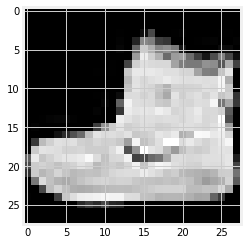

In [4]:
# Sample 0: boot
sample_num = 0
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 0


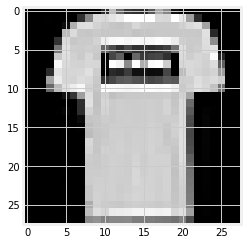

In [5]:
# Sample 1: shirt
sample_num = 1
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 3


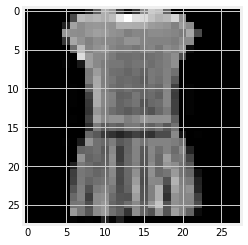

In [6]:
# Sample 3: dress
sample_num = 3
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

In [7]:
min_pixel_value = train_dataset[sample_num][0].min()
max_pixel_value = train_dataset[sample_num][0].max()

print(f'Minimum pixel value: {min_pixel_value}')
print(f'Maximum pixel value: {max_pixel_value}')

Minimum pixel value: 0.0
Maximum pixel value: 1.0


/home/ritchie/miniconda3/envs/latest/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Sigmoid Function')

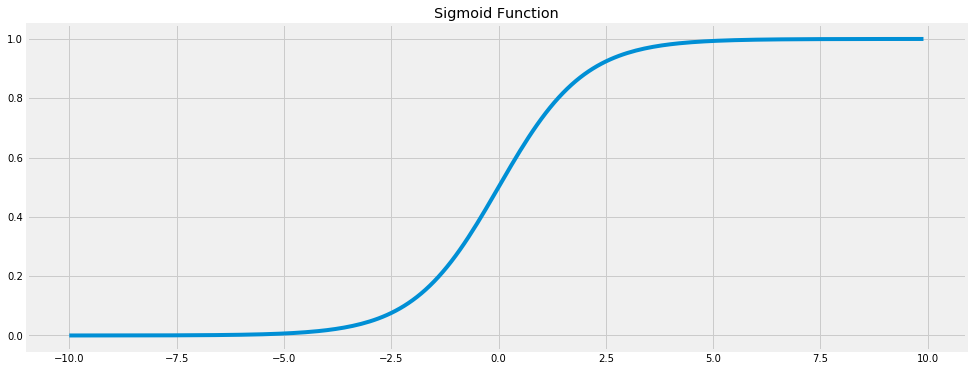

In [8]:
# Sigmoid function has function bounded by min=0 and max=1
# So this will be what we will be using for the final layer's function
x = torch.arange(-10., 10., 0.1)
plt.figure(figsize=figsize);
plt.plot(x.numpy(), F.sigmoid(x).numpy())
plt.title('Sigmoid Function')

In [9]:
# Model definition
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: affine function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = F.sigmoid(out)
        
        return out

In [10]:
# Dimensions for overcomplete (larger latent representation)
input_dim = 28*28
hidden_dim = int(input_dim * 1.5)
output_dim = input_dim

# Instantiate Fully-connected Autoencoder (FC-AE)
# And assign to model object
model = FullyConnectedAutoencoder(input_dim, hidden_dim, output_dim)

In [11]:
# We want to minimize the per pixel reconstruction loss
# So we've to use the mean squared error (MSE) loss
# This is similar to our regression tasks' loss
criterion = nn.MSELoss()

In [12]:
# Using basic Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [13]:
# Parameter inspection
num_params_group = len(list(model.parameters()))
for group_idx in range(num_params_group):
    print(list(model.parameters())[group_idx].size())

torch.Size([1176, 784])
torch.Size([1176])
torch.Size([784, 1176])
torch.Size([784])


In [14]:
idx = 0
# Dropout for creating noisy images
# by dropping out pixel with a 50% probability
dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()
        
        # Noisy images
        noisy_images = dropout(torch.ones(images.shape)) * images

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(noisy_images)

        # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
        loss = criterion(outputs, images)

        # Getting gradients w.r.t. parameters via backpropagation
        loss.backward()

        # Updating parameters via gradient descent
        optimizer.step()

        idx += 1

        if idx % 500 == 0:
            # Calculate MSE Test Loss
            total_test_loss = 0
            total_samples = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                # Noisy images
                noisy_images = dropout(torch.ones(images.shape)) * images
                
                # Forward pass only to get logits/output
                outputs = model(noisy_images.view(-1, 28*28))

                # Test loss
                test_loss = criterion(outputs, images.view(-1, 28*28))

                # Total number of labels
                total_samples += labels.size(0)

                # Total test loss
                total_test_loss += test_loss

            mean_test_loss = total_test_loss / total_samples

            # Print Loss
            print(f'Iteration: {idx}. Average Test Loss: {mean_test_loss.item()}.')

Iteration: 500. Average Test Loss: 0.00016266175953205675.
Iteration: 1000. Average Test Loss: 0.00014029155136086047.
Iteration: 1500. Average Test Loss: 0.000131278284243308.
Iteration: 2000. Average Test Loss: 0.000124645623145625.
Iteration: 2500. Average Test Loss: 0.00012160430196672678.
Iteration: 3000. Average Test Loss: 0.00011795523460023105.
Iteration: 3500. Average Test Loss: 0.00011594038369366899.
Iteration: 4000. Average Test Loss: 0.00011425256525399163.
Iteration: 4500. Average Test Loss: 0.00011265648936387151.


Label 4


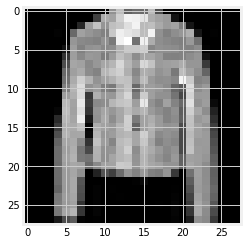

In [15]:
# Test sample 3: Raw
sample_num = 10
raw_img = test_dataset[sample_num][0]
show_img = raw_img.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 4


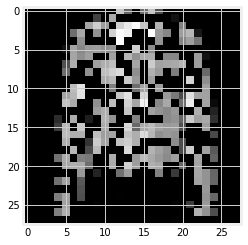

In [16]:
# Test sample 3: Noisy
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
show_img = noisy_image.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

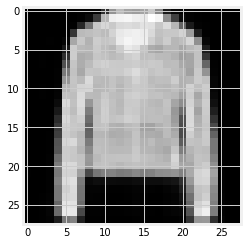

In [17]:
# Test sample 3: Run on Inference
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
outputs = model(noisy_image.view(-1, 28*28))
show_img = outputs.detach().numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray');